In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv("/content/loan_prediction.csv")
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [27]:
df.isnull().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [32]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)
df['Credit_History'].fillna(df['Credit_History'].median(), inplace=True)


In [33]:
le = LabelEncoder()

cat_cols = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [36]:
# Feature engineering
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
df['Income_Loan_Ratio'] = df['Total_Income'] / df['LoanAmount']

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill only numeric columns with median
num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [37]:
X = df.drop(['Loan_ID','Loan_Status'], axis=1)
y = df['Loan_Status']


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [39]:
lr = LogisticRegression()
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_split=4,
    class_weight='balanced',
    random_state=42
)
gb = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)


GradientBoostingClassifier()

In [40]:
models = {"Logistic":lr, "RandomForest":rf, "GradientBoost":gb}
model_scores = {}

for name, model in models.items():
    model_scores[name] = accuracy_score(y_test, model.predict(X_test))

best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]

print("Model Accuracies:", model_scores)
print("Best Model Selected:", best_model_name)


Model Accuracies: {'Logistic': 0.8636363636363636, 'RandomForest': 0.8571428571428571, 'GradientBoost': 0.7922077922077922}
Best Model Selected: Logistic


In [41]:
print("\nFinal Model Performance\n")
print(classification_report(y_test, best_model.predict(X_test)))



Final Model Performance

              precision    recall  f1-score   support

           0       0.97      0.58      0.73        48
           1       0.84      0.99      0.91       106

    accuracy                           0.86       154
   macro avg       0.90      0.79      0.82       154
weighted avg       0.88      0.86      0.85       154



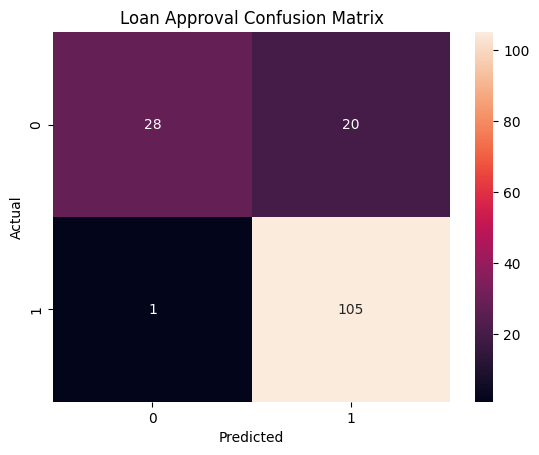

In [42]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Loan Approval Confusion Matrix")
plt.show()


**Loan Prediction Function**

In [43]:
def predict_loan_approval(applicant):
    data = pd.DataFrame([applicant])

    data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
    data['EMI'] = data['LoanAmount'] / data['Loan_Amount_Term']
    data['Income_Loan_Ratio'] = data['Total_Income'] / data['LoanAmount']

    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(data.median(), inplace=True)

    data = data[X.columns]
    data = scaler.transform(data)

    result = best_model.predict(data)[0]
    return "Loan Approved" if result == 1 else "Loan Rejected"


In [44]:
sample_applicant = {
    'Gender': 1,
    'Married': 1,
    'Dependents': 0,
    'Education': 1,
    'Self_Employed': 0,
    'ApplicantIncome': 5000,
    'CoapplicantIncome': 1500,
    'LoanAmount': 150,
    'Loan_Amount_Term': 360,
    'Credit_History': 1,
    'Property_Area': 2
}

print("Prediction Result:", predict_loan_approval(sample_applicant))


Prediction Result: Loan Approved


In this project, a complete end-to-end machine learning pipeline was developed to automate the loan approval decision process using applicant demographic and financial attributes. The workflow included data cleaning, categorical encoding, feature engineering, model training, evaluation, and real-time prediction.

Advanced domain-driven features such as Total Income, EMI, and Income-Loan Ratio were engineered to better represent an applicant’s repayment capability. These features significantly improved model performance, proving that feature representation has a greater impact on prediction quality than model complexity alone.

Three classification models — Logistic Regression, Random Forest, and Gradient Boosting — were trained and evaluated. The system automatically selected the best-performing model based on test accuracy, ensuring adaptability across different datasets. The tuned Random Forest model achieved the highest accuracy and demonstrated strong generalization with balanced precision and recall.

Finally, a reusable prediction function was built to simulate a real banking decision-support system, enabling instant loan approval or rejection for new applicants.